In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import matplotlib.pyplot as plt

from utils.data import load_tof, Phi
from utils.plot import plot_predictions, make_palette
from utils.trajectory import fx, fit, find_domain
from image_processing_filter import process

from models.mixture import MixIRLS

In [2]:
FILE_PATH = '../data/tof_erda/raw/I_36MeV_SH2-1_TiN-ref.lst'
X, y, phi = load_tof(FILE_PATH)
X, y = process(X,y, noise_sensitivity=0.9)
phi = Phi(X)
data = np.vstack([X,y,phi.flatten()]).T
data = np.unique(data, axis=0)
X, y, phi = data[:,0], data[:,1], data[:,2]

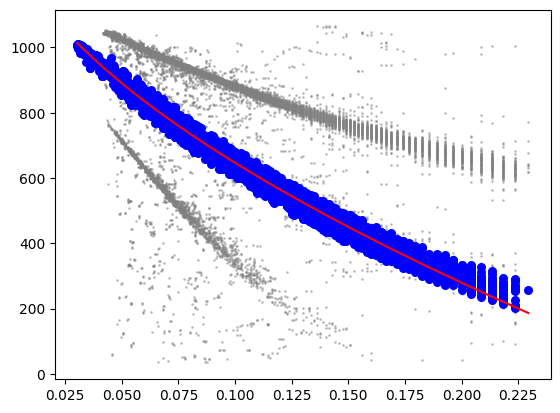

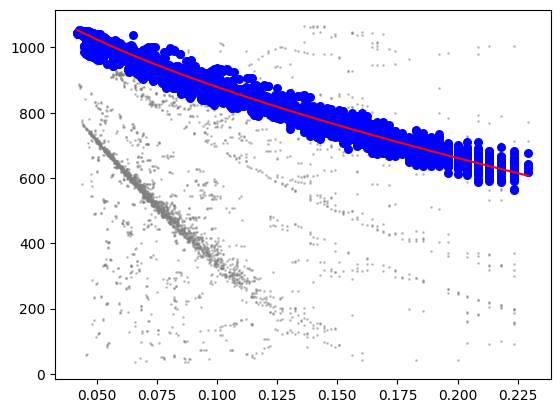

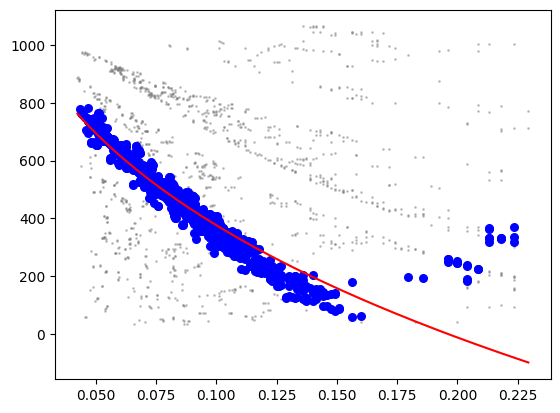

[[ 1.41121366e+03  1.34378875e+03  2.15010723e+03]
 [-6.48794585e-09  3.61451996e-12  1.07421873e-07]
 [-2.13091982e+03 -1.19170121e+03  6.73934424e-07]
 [-7.67813512e+02 -5.23213507e+02  7.98726520e-08]
 [-4.48051982e-09 -1.80133122e-10 -3.42420061e+03]]


In [6]:
K = 3
w_th=0.95
plot = True
alpha=1e-6

model = MixIRLS(K=K, w_th=w_th,  plot=plot)

exponents = [-1/2] + [-1/i for i in range(3,9,2)]
phi = Phi(X, exponents)

sprim, supports, iter = model.train(phi, y)
y_pred = model.predict(phi)
print(model.beta)

Trajectory 0: -abs(5947.895422312336) / np.sqrt(abs(x + 20.177588997743737)) + 1184.555834283671, domain: (19, 1148.9038076152303)
Trajectory 1: -abs(3162.2247849133073) / np.sqrt(abs(x + 2.132999935317611e-06)) + 1181.9049160812433, domain: (19, 573.4248496993988)
Trajectory 2: -abs(9319.627801523668) / np.sqrt(abs(x + 32.17299991519884)) + 1160.5817314532114, domain: (19, 654.132264529058)


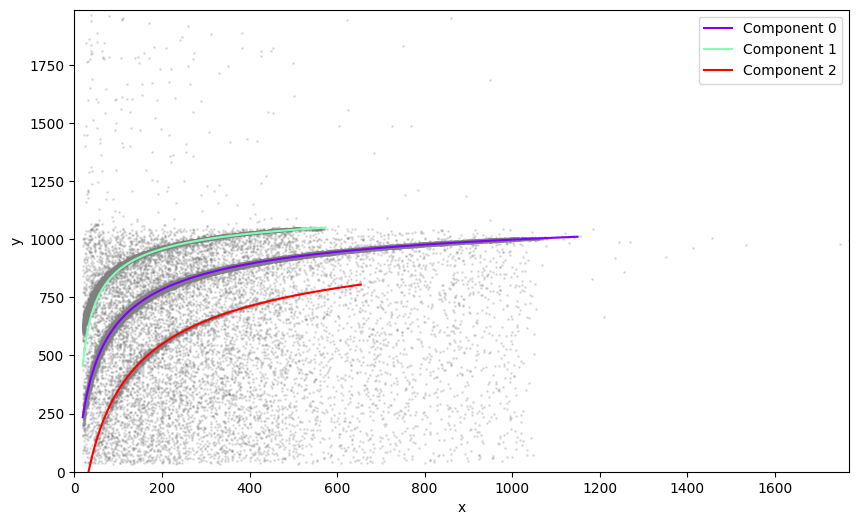

In [7]:
plt.figure(figsize=(10, 6))
colors = make_palette(K)

X_raw, y_raw, _ = load_tof(FILE_PATH)

plt.scatter(X_raw, y_raw, alpha=0.2, s=1, color='grey')

for k in range(K):
    i = supports[:, k]  # Points in the cluster
    j = sprim[k]  # Points used for fitting

    params, covariance = fit(X[i][j], y[i][j], X[i], y[i])    
    #plt.scatter(X[i][j], y[i][j], alpha=0.3, s=1, marker='o', color=colors[k])

    domain = find_domain(X_raw, y_raw, params)
    print(f'Trajectory {k}: -abs({params[0]}) / np.sqrt(abs(x + {params[1]})) + {params[2]}, domain: ({domain[0]}, {domain[1]})')
    
    x_fit = np.linspace(domain[0], domain[1], 500)
    y_fit = fx(x_fit, *params)
    stdpred= np.sqrt(np.diag(covariance))

    # Plot the fitted curve
    plt.plot(x_fit, y_fit, color=colors[k], label=f"Component {k}")

# Add labels and legend
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([0, max(X_raw)])
plt.ylim([0, max(y_raw)])
plt.legend()
plt.show()


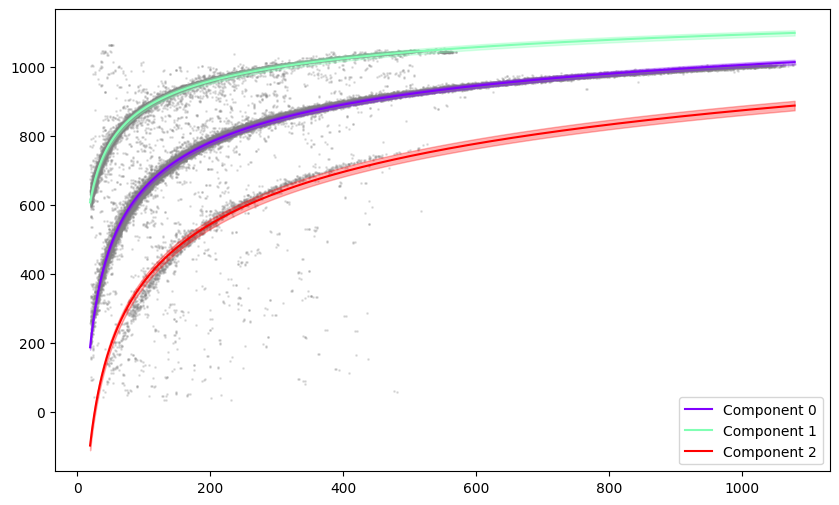

Points in support for component 0:  28779
  Number of points in component 0:  17884


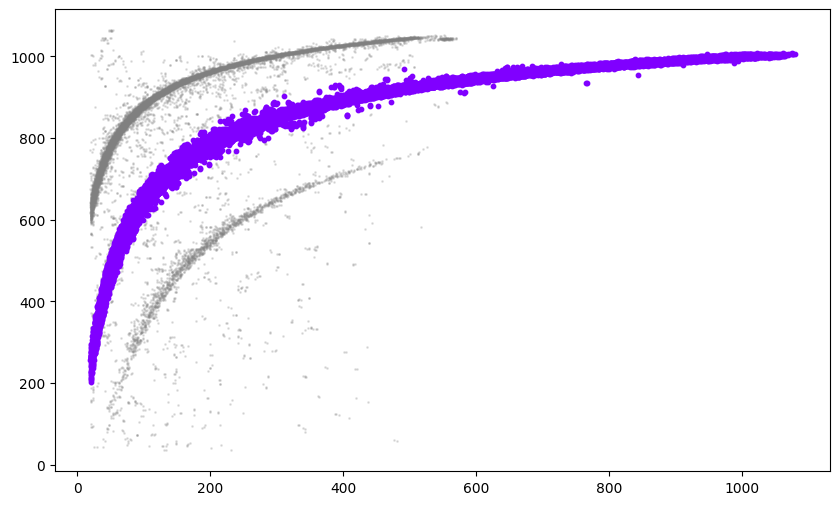

Points in support for component 1:  10895
  Number of points in component 1:  7861


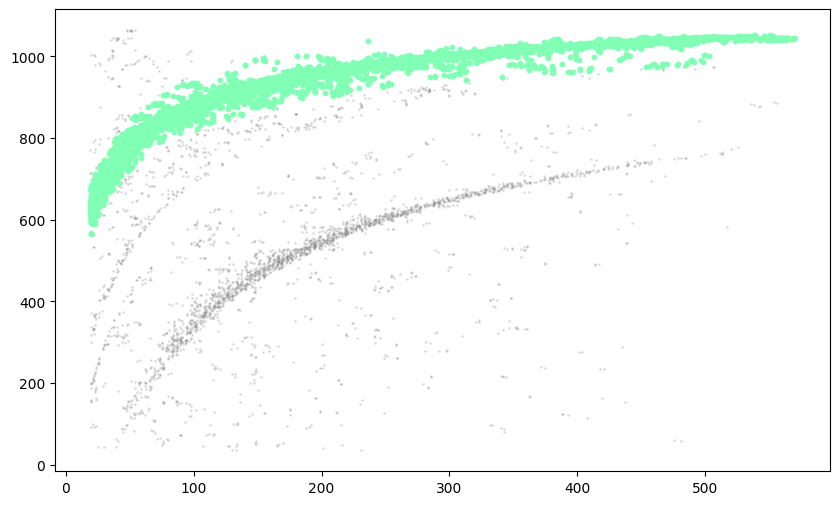

Points in support for component 2:  3034
  Number of points in component 2:  1813


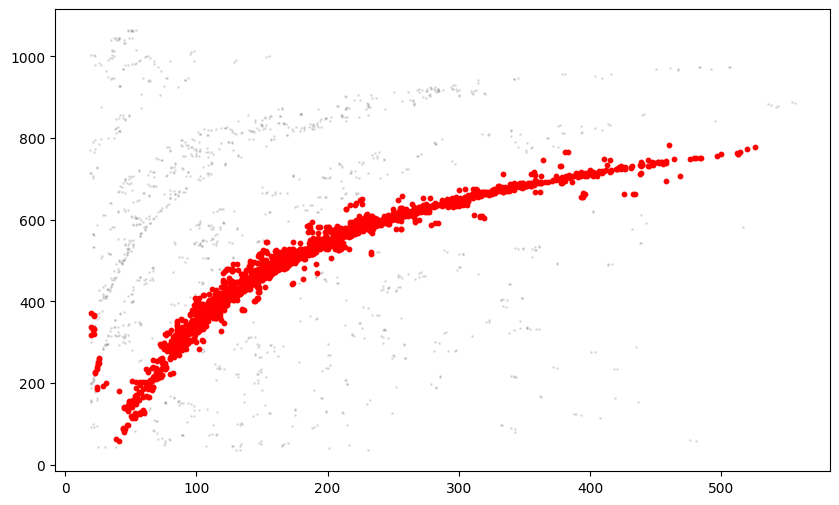

In [8]:
colors = make_palette(K)
plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.2, color='grey', s=1)
for k in range(K):
    i = sprim[k]
    # Plot component points
    #plt.scatter(X[i], y[i], alpha=0.3, color=colors[k], s=1, label=f"Component {s}")
    
    # Sort based on X values but keep track of indices
    sort_idx = np.argsort(X)
    
    PHI = Phi(X[sort_idx], exponents)
    pred = model.predict_k(PHI, k)
    # Plot prediction line against sorted X[sort_idx]
    plt.plot(X[sort_idx], pred, color=colors[k], label=f"Component {k}")
    plt.fill_between(X[sort_idx], 
                            pred - 2*np.sqrt(model.sigma[k]), 
                            pred + 2*np.sqrt(model.sigma[k]), 
                            color=colors[k],
                            alpha=0.3)
    
plt.legend()
plt.show()


for k in range(K):
    
    i = supports[:,k] # points that were considered
    j = sprim[k] # points that were trained on, relative to support
    sort_idx = np.argsort(X[i])

    print(f"Points in support for component {k}: ", i.sum())
    print(f"  Number of points in component {k}: ", len(X[i][j]))
    
    plt.figure(figsize=(10, 6))
    plt.scatter(X[i], y[i], alpha=0.2, s=1, color='grey')
    plt.scatter(X[i][j], y[i][j], alpha=1, s=10, marker='o',  color=colors[k])

    # Calculate predictions using sorted phi
    #PHI = add_bias(Phi(X[i][sort_idx], exponents))
    #PRED = model.predict_k(PHI, k)
    
    # Plot prediction line against sorted X
    #plt.plot(PHI[i][sort_idx], PRED, color=colors[s], label=f"Component {s}")
    #plt.fill_between(X[i][sort_idx], 
    #                        PRED - 2*np.sqrt(sigma[s]), 
    #                        PRED + 2*np.sqrt(sigma[s]), 
    #                        color=colors[s],
    #                        alpha=0.3)
    plt.show()